In [2]:
!pip install tensorflow

DEPRECATION: Loading egg at c:\users\91918\anaconda3\lib\site-packages\cences_income-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
# Load the dataset
data = np.loadtxt('C:/Users/91918/Music/ECG normal/ECG200_TRAIN.txt')  # Update the path to the ECG dataset
labels = data[:, 0]  # Labels are in the first column
data = data[:, 1:]   # ECG data

In [4]:
# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)


In [5]:
# Normalize the data to [0,1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
# Convert labels to boolean for anomaly detection (1 = normal, -1 = anomaly)
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [7]:
# Separate normal and anomalous data
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

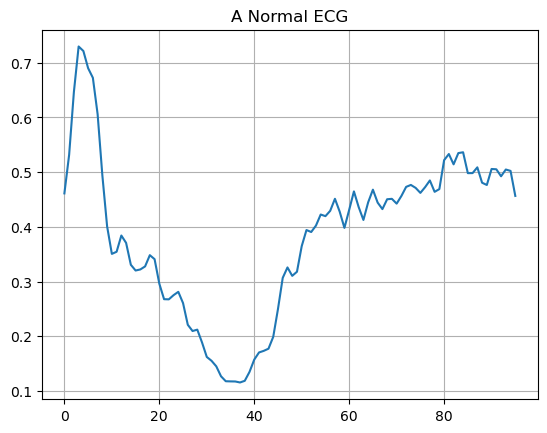

In [11]:
# Plot a normal ECG
plt.grid()
plt.plot(np.arange(normal_train_data.shape[1]), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()



In [13]:
# Plot an anomalous ECG
if anomalous_train_data.shape[0] > 0:
    # Plot an anomalous ECG from the training set
    plt.grid()
    plt.plot(np.arange(anomalous_train_data.shape[1]), anomalous_train_data[0])
    plt.title("An Anomalous ECG")
    plt.show()
else:
    print("No anomalous data in the training set. Plotting from the test set instead.")
    if anomalous_test_data.shape[0] > 0:
        plt.grid()
        plt.plot(np.arange(anomalous_test_data.shape[1]), anomalous_test_data[0])
        plt.title("An Anomalous ECG from Test Set")
        plt.show()
    else:
        print("No anomalous data in the test set either.")


No anomalous data in the training set. Plotting from the test set instead.
No anomalous data in the test set either.


In [14]:
# Build the Anomaly Detector model
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(train_data.shape[1], activation="sigmoid")
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [15]:
# Instantiate and compile the model
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [16]:
# Train the autoencoder using only normal ECG data
history = autoencoder.fit(
    normal_train_data, normal_train_data,
    epochs=20,
    batch_size=512,
    validation_data=(test_data, test_data),
    shuffle=True
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1411 - val_loss: 0.1433
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1403 - val_loss: 0.1428
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1397 - val_loss: 0.1423
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1392 - val_loss: 0.1418
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1388 - val_loss: 0.1415
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1384 - val_loss: 0.1411
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1380 - val_loss: 0.1407
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1376 - val_loss: 0.1402
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1372 - val_loss: 0.1398
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1368 - val_loss: 0.1393
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1363 - val_loss: 0.1387
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1357 - val_loss: 0.1381
Ep

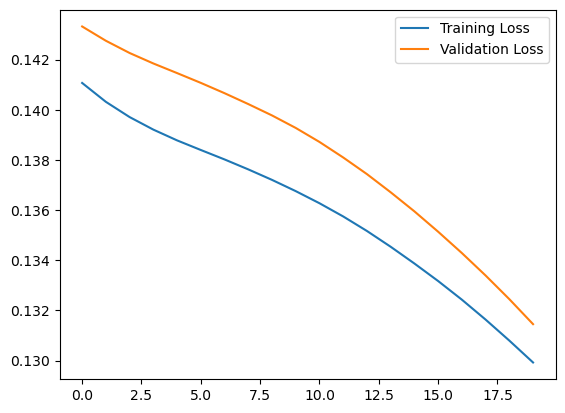

In [17]:
# Plot training history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


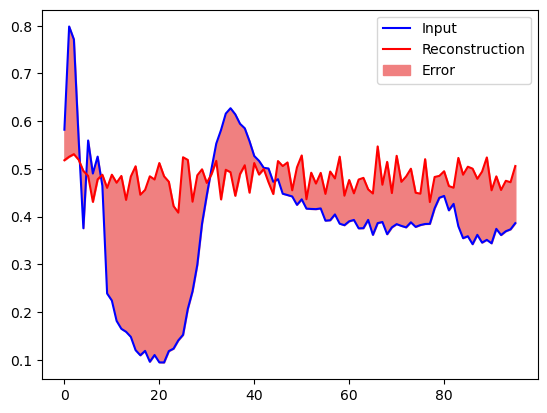

In [18]:
# Visualize the reconstructions for normal ECG
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(normal_test_data.shape[1]), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()


In [20]:
# Visualize the reconstructions for anomalous ECG
# Check if anomalous_test_data is empty
if anomalous_test_data.shape[0] > 0:
    # Visualize the reconstructions for anomalous ECG
    encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    
    # Plot the original and reconstructed data
    plt.plot(anomalous_test_data[0], 'b', label="Input")
    plt.plot(decoded_data[0], 'r', label="Reconstruction")
    plt.fill_between(np.arange(anomalous_test_data.shape[1]), decoded_data[0], anomalous_test_data[0], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.title("Anomalous ECG - Input vs Reconstruction")
    plt.show()
else:
    print("No anomalous data found in the test set.")


No anomalous data found in the test set.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


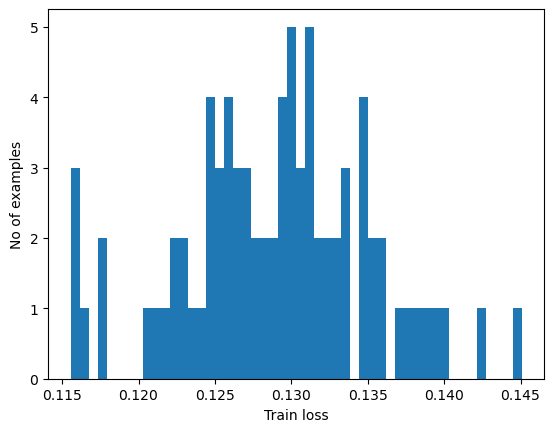

In [21]:
# Compute reconstruction loss on normal training data
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [22]:
# Set threshold for anomaly detection
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.13513957


In [24]:
# Compute reconstruction loss on anomalous test data
# Check if there are any anomalies in the test set
if anomalous_test_data.shape[0] > 0:
    # Compute reconstruction loss on anomalous test data
    reconstructions = autoencoder.predict(anomalous_test_data)
    test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

    # Plot a histogram of the reconstruction losses
    plt.hist(test_loss[None, :], bins=50)
    plt.xlabel("Test loss")
    plt.ylabel("No of examples")
    plt.show()
else:
    print("No anomalous data found in the test set. Cannot compute reconstruction loss.")


No anomalous data found in the test set. Cannot compute reconstruction loss.


In [25]:
# Define prediction and evaluation functions
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))



In [26]:
# Predict and print stats
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.7
Precision = 1.0
Recall = 0.7
